In [4]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [5]:
# Download do dataset MNIST into data dir
import os

os.makedirs("data", exist_ok=True)
!python -m wget -o data/mnist_train.csv https://pjreddie.com/media/files/mnist_train.csv


Saved under data/mnist_train (1).csv


In [6]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]
        # As demais colunas são os pixels da imagem
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

In [8]:
# Criando índices aleatórios para os subsets de treino e teste
np.random.seed(42)
indices = np.arange(len(mnist_dataset))
np.random.shuffle(indices)

# Dividindo os índices em trainset e testset
num_train = 1000
num_val = 500
num_test = 500
train_indices = indices[:num_train]  # Primeiros 1.000 índices para o trainset
val_indices = indices[num_train:num_train+num_val]  # Próximos 500 índices para o valset
test_indices = indices[num_train+num_val:num_train+num_val+num_test]  # Mais 500 para o testset

trainset = Subset(mnist_dataset, train_indices)
valset = Subset(mnist_dataset, val_indices)
testset = Subset(mnist_dataset, test_indices)

# Criando DataLoaders para os subsets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [9]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }
    
    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')
        
        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [10]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 12 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [11]:
model = CNN(
    initialize_weights=True,
    dropout=0.2
)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [13]:
# Treinando a CNN
history = train_model(
    model=model,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
)

100%|██████████| 16/16 [00:00<00:00, 31.13it/s]


Epoch 1, Train Loss: 2.298, Train Accuracy: 13.20%
Epoch 1, Val Loss: 2.244, Val Accuracy: 17.40%


100%|██████████| 16/16 [00:00<00:00, 36.15it/s]


Epoch 2, Train Loss: 2.101, Train Accuracy: 31.60%
Epoch 2, Val Loss: 1.915, Val Accuracy: 41.40%


100%|██████████| 16/16 [00:00<00:00, 36.61it/s]


Epoch 3, Train Loss: 1.556, Train Accuracy: 49.40%
Epoch 3, Val Loss: 1.133, Val Accuracy: 63.20%


100%|██████████| 16/16 [00:00<00:00, 39.49it/s]


Epoch 4, Train Loss: 0.950, Train Accuracy: 68.60%
Epoch 4, Val Loss: 0.758, Val Accuracy: 74.00%


100%|██████████| 16/16 [00:00<00:00, 30.86it/s]


Epoch 5, Train Loss: 0.652, Train Accuracy: 78.70%
Epoch 5, Val Loss: 0.584, Val Accuracy: 82.00%
Treinamento concluído


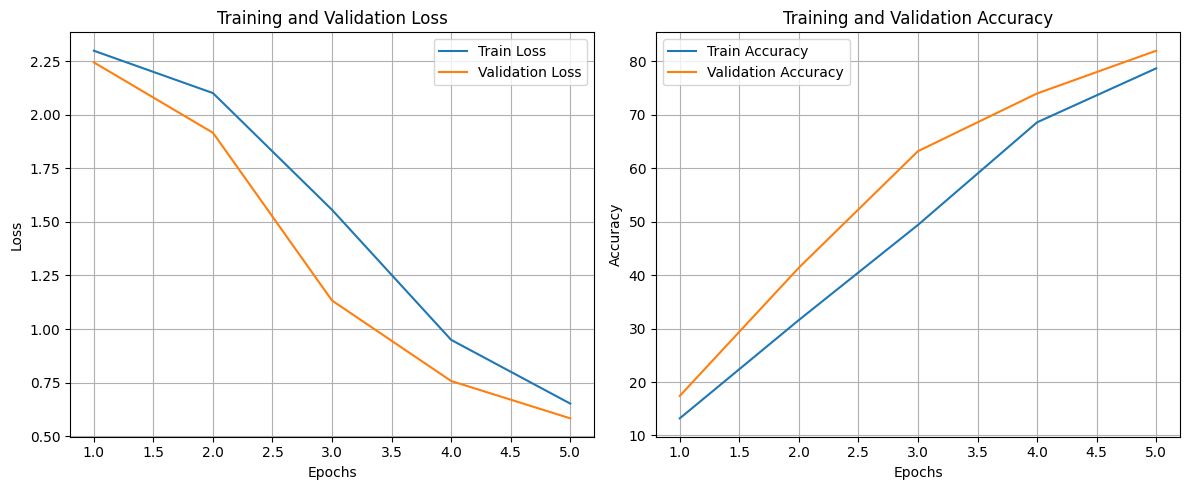

In [14]:
epochs = range(1, len(history['train_losses']) + 1)
    
# Plot de losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, history['train_losses'], label='Train Loss')
plt.plot(epochs, history['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot de accuracies
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
test_model(model, testloader)

Acurácia da rede na base de teste: 83.80%


## Exercícios

### Exercício 1
Na CNN implementada, execute experimentos variando:
- O número de filtros convolucionais em `self.conv1` (6 e 8)
- O número de filtros convolucionais em `self.conv2` (12 e 16)

Ao final, observe qual combinação desempenha melhor no conjunto de testes.

Dica: Adicionar argumentos no construtor da classe para determinar o número de filtros em cada camada pode ser útil para inicializar diversos modelos.

In [22]:
# Exercício 1: Variando o número de filtros convolucionais
class CNN_Variando_Filtros(nn.Module):
    def __init__(self, num_filters1=6, num_filters2=12, initialize_weights=True, dropout=0.2):
        super(CNN_Variando_Filtros, self).__init__()
        self.conv1 = nn.Conv2d(1, num_filters1, 5)
        self.conv2 = nn.Conv2d(num_filters1, num_filters2, 5)
        self.fc1 = nn.Linear(num_filters2 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, self.conv2.out_channels * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

# Experimentando as combinações de filtros
num_filters_combinations = [(6, 12), (8, 12), (6, 16), (8, 16)]

best_accuracy = 0
best_combination = None

for num_filters1, num_filters2 in num_filters_combinations:
    print(f"Treinando com conv1: {num_filters1} filtros, conv2: {num_filters2} filtros")
    
    model = CNN_Variando_Filtros(num_filters1=num_filters1, num_filters2=num_filters2)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Treinando o modelo
    history = train_model(
        model=model,
        trainloader=trainloader,
        valloader=valloader,
        criterion=criterion,
        optimizer=optimizer
    )

    # Testando no conjunto de testes
    print(f"Testando com conv1: {num_filters1}, conv2: {num_filters2}")
    test_model(model, testloader)
    print()

    # Comparando a acurácia e armazenando a melhor combinação
    final_accuracy = history['val_accuracies'][-1]
    if final_accuracy > best_accuracy:
        best_accuracy = final_accuracy
        best_combination = (num_filters1, num_filters2)

print(f"\nMelhor combinação de filtros: conv1={best_combination[0]}, conv2={best_combination[1]}")
print(f"Acurácia final com a melhor combinação: {best_accuracy:.2f}%")


Treinando com conv1: 6 filtros, conv2: 12 filtros


100%|██████████| 16/16 [00:00<00:00, 26.51it/s]


Epoch 1, Train Loss: 2.239, Train Accuracy: 16.60%
Epoch 1, Val Loss: 2.075, Val Accuracy: 36.80%


100%|██████████| 16/16 [00:00<00:00, 42.71it/s]


Epoch 2, Train Loss: 1.781, Train Accuracy: 45.30%
Epoch 2, Val Loss: 1.183, Val Accuracy: 69.20%


100%|██████████| 16/16 [00:00<00:00, 43.30it/s]


Epoch 3, Train Loss: 1.003, Train Accuracy: 65.90%
Epoch 3, Val Loss: 0.634, Val Accuracy: 79.80%


100%|██████████| 16/16 [00:00<00:00, 45.27it/s]


Epoch 4, Train Loss: 0.679, Train Accuracy: 76.70%
Epoch 4, Val Loss: 0.438, Val Accuracy: 84.80%


100%|██████████| 16/16 [00:00<00:00, 45.34it/s]


Epoch 5, Train Loss: 0.522, Train Accuracy: 82.40%
Epoch 5, Val Loss: 0.438, Val Accuracy: 85.00%
Treinamento concluído
Testando com conv1: 6, conv2: 12
Acurácia da rede na base de teste: 89.00%

Treinando com conv1: 8 filtros, conv2: 12 filtros


100%|██████████| 16/16 [00:00<00:00, 42.70it/s]


Epoch 1, Train Loss: 2.225, Train Accuracy: 21.70%
Epoch 1, Val Loss: 2.064, Val Accuracy: 30.40%


100%|██████████| 16/16 [00:00<00:00, 43.10it/s]


Epoch 2, Train Loss: 1.738, Train Accuracy: 41.60%
Epoch 2, Val Loss: 1.231, Val Accuracy: 65.80%


100%|██████████| 16/16 [00:00<00:00, 43.37it/s]


Epoch 3, Train Loss: 1.107, Train Accuracy: 63.10%
Epoch 3, Val Loss: 0.766, Val Accuracy: 72.80%


100%|██████████| 16/16 [00:00<00:00, 46.69it/s]


Epoch 4, Train Loss: 0.744, Train Accuracy: 73.50%
Epoch 4, Val Loss: 0.541, Val Accuracy: 81.80%


100%|██████████| 16/16 [00:00<00:00, 44.90it/s]


Epoch 5, Train Loss: 0.559, Train Accuracy: 82.50%
Epoch 5, Val Loss: 0.420, Val Accuracy: 85.60%
Treinamento concluído
Testando com conv1: 8, conv2: 12
Acurácia da rede na base de teste: 88.00%

Treinando com conv1: 6 filtros, conv2: 16 filtros


100%|██████████| 16/16 [00:00<00:00, 44.85it/s]


Epoch 1, Train Loss: 2.273, Train Accuracy: 23.20%
Epoch 1, Val Loss: 2.152, Val Accuracy: 31.40%


100%|██████████| 16/16 [00:00<00:00, 45.36it/s]


Epoch 2, Train Loss: 1.918, Train Accuracy: 39.40%
Epoch 2, Val Loss: 1.500, Val Accuracy: 58.20%


100%|██████████| 16/16 [00:00<00:00, 43.99it/s]


Epoch 3, Train Loss: 1.288, Train Accuracy: 57.70%
Epoch 3, Val Loss: 0.825, Val Accuracy: 76.40%


100%|██████████| 16/16 [00:00<00:00, 42.85it/s]


Epoch 4, Train Loss: 0.826, Train Accuracy: 72.10%
Epoch 4, Val Loss: 0.585, Val Accuracy: 82.80%


100%|██████████| 16/16 [00:00<00:00, 45.64it/s]


Epoch 5, Train Loss: 0.563, Train Accuracy: 80.20%
Epoch 5, Val Loss: 0.452, Val Accuracy: 86.40%
Treinamento concluído
Testando com conv1: 6, conv2: 16
Acurácia da rede na base de teste: 89.00%

Treinando com conv1: 8 filtros, conv2: 16 filtros


100%|██████████| 16/16 [00:00<00:00, 44.93it/s]


Epoch 1, Train Loss: 2.195, Train Accuracy: 21.50%
Epoch 1, Val Loss: 1.919, Val Accuracy: 48.60%


100%|██████████| 16/16 [00:00<00:00, 39.52it/s]


Epoch 2, Train Loss: 1.505, Train Accuracy: 52.60%
Epoch 2, Val Loss: 0.870, Val Accuracy: 75.60%


100%|██████████| 16/16 [00:00<00:00, 43.07it/s]


Epoch 3, Train Loss: 0.820, Train Accuracy: 72.40%
Epoch 3, Val Loss: 0.526, Val Accuracy: 84.60%


100%|██████████| 16/16 [00:00<00:00, 43.62it/s]


Epoch 4, Train Loss: 0.548, Train Accuracy: 81.50%
Epoch 4, Val Loss: 0.444, Val Accuracy: 87.40%


100%|██████████| 16/16 [00:00<00:00, 41.85it/s]


Epoch 5, Train Loss: 0.408, Train Accuracy: 87.20%
Epoch 5, Val Loss: 0.367, Val Accuracy: 90.20%
Treinamento concluído
Testando com conv1: 8, conv2: 16
Acurácia da rede na base de teste: 91.60%


Melhor combinação de filtros: conv1=8, conv2=16
Acurácia final com a melhor combinação: 90.20%


### Exercício 2

Na CNN implementada, execute 5 treinamentos variando aleatoriamente o número de neurônios de saída em `self.fc1` (o valor atual é 64 e também deve ser alterado na entrada da próxima camada).

Como você determinaria qual foi o melhor valor?

In [26]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2, num_fc1_neurons=64):
        super(CNN, self).__init__()
        
        # Definir o número de filtros
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)

        # Número de neurônios na camada fully connected (passado como argumento)
        self.fc1_neurons = num_fc1_neurons
        
        # A camada fc1 precisa ser ajustada para o tamanho da saída de conv2
        self.fc1 = nn.Linear(12 * 4 * 4, self.fc1_neurons)  # Ajuste conforme a saída de conv2
        self.fc2 = nn.Linear(self.fc1_neurons, 10)  # 10 classes de saída
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # Passagem pela camada convolucional e pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 12 * 4 * 4)  # Ajuste conforme a saída da convolução
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


# Exercício 2: Variando o número de neurônios em self.fc1
for i in range(5):
    # Gerar um número aleatório de neurônios para a camada totalmente conectada
    num_neurons = np.random.randint(10, 100)
    print(f'Número de neurônios na camada fully connected: {num_neurons}')

    # Recriar a arquitetura com o número de neurônios aleatório
    model = CNN(
        initialize_weights=True,
        dropout=0.2,
        num_fc1_neurons=num_neurons  # Passar o número de neurônios aleatório para a camada fc1
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Treinando o modelo
    history = train_model(
        model=model,
        trainloader=trainloader,
        valloader=valloader,
        criterion=criterion,
        optimizer=optimizer
    )

    # Testando o modelo
    test_model(model, testloader)
    print()

Número de neurônios na camada fully connected: 61


100%|██████████| 16/16 [00:00<00:00, 47.63it/s]


Epoch 1, Train Loss: 2.287, Train Accuracy: 14.30%
Epoch 1, Val Loss: 2.183, Val Accuracy: 18.20%


100%|██████████| 16/16 [00:00<00:00, 41.80it/s]


Epoch 2, Train Loss: 2.021, Train Accuracy: 36.80%
Epoch 2, Val Loss: 1.703, Val Accuracy: 55.00%


100%|██████████| 16/16 [00:00<00:00, 47.95it/s]


Epoch 3, Train Loss: 1.436, Train Accuracy: 54.20%
Epoch 3, Val Loss: 0.935, Val Accuracy: 72.40%


100%|██████████| 16/16 [00:00<00:00, 46.54it/s]


Epoch 4, Train Loss: 0.957, Train Accuracy: 67.80%
Epoch 4, Val Loss: 0.599, Val Accuracy: 81.60%


100%|██████████| 16/16 [00:00<00:00, 44.68it/s]


Epoch 5, Train Loss: 0.667, Train Accuracy: 77.50%
Epoch 5, Val Loss: 0.435, Val Accuracy: 88.00%
Treinamento concluído
Acurácia da rede na base de teste: 86.80%

Número de neurônios na camada fully connected: 20


100%|██████████| 16/16 [00:00<00:00, 45.92it/s]


Epoch 1, Train Loss: 2.273, Train Accuracy: 11.30%
Epoch 1, Val Loss: 2.164, Val Accuracy: 23.00%


100%|██████████| 16/16 [00:00<00:00, 44.87it/s]


Epoch 2, Train Loss: 2.107, Train Accuracy: 24.50%
Epoch 2, Val Loss: 1.912, Val Accuracy: 34.80%


100%|██████████| 16/16 [00:00<00:00, 45.77it/s]


Epoch 3, Train Loss: 1.826, Train Accuracy: 33.00%
Epoch 3, Val Loss: 1.595, Val Accuracy: 42.20%


100%|██████████| 16/16 [00:00<00:00, 48.07it/s]


Epoch 4, Train Loss: 1.501, Train Accuracy: 46.00%
Epoch 4, Val Loss: 1.151, Val Accuracy: 67.20%


100%|██████████| 16/16 [00:00<00:00, 47.83it/s]


Epoch 5, Train Loss: 1.156, Train Accuracy: 60.80%
Epoch 5, Val Loss: 0.788, Val Accuracy: 76.80%
Treinamento concluído
Acurácia da rede na base de teste: 79.60%

Número de neurônios na camada fully connected: 31


100%|██████████| 16/16 [00:00<00:00, 48.62it/s]


Epoch 1, Train Loss: 2.251, Train Accuracy: 15.60%
Epoch 1, Val Loss: 2.115, Val Accuracy: 33.40%


100%|██████████| 16/16 [00:00<00:00, 42.13it/s]


Epoch 2, Train Loss: 1.907, Train Accuracy: 35.50%
Epoch 2, Val Loss: 1.495, Val Accuracy: 54.60%


100%|██████████| 16/16 [00:00<00:00, 45.09it/s]


Epoch 3, Train Loss: 1.274, Train Accuracy: 58.10%
Epoch 3, Val Loss: 0.888, Val Accuracy: 71.60%


100%|██████████| 16/16 [00:00<00:00, 46.28it/s]


Epoch 4, Train Loss: 0.904, Train Accuracy: 69.70%
Epoch 4, Val Loss: 0.644, Val Accuracy: 79.60%


100%|██████████| 16/16 [00:00<00:00, 44.75it/s]


Epoch 5, Train Loss: 0.682, Train Accuracy: 77.60%
Epoch 5, Val Loss: 0.530, Val Accuracy: 83.60%
Treinamento concluído
Acurácia da rede na base de teste: 86.40%

Número de neurônios na camada fully connected: 56


100%|██████████| 16/16 [00:00<00:00, 50.68it/s]


Epoch 1, Train Loss: 2.244, Train Accuracy: 18.70%
Epoch 1, Val Loss: 2.121, Val Accuracy: 38.20%


100%|██████████| 16/16 [00:00<00:00, 42.57it/s]


Epoch 2, Train Loss: 1.883, Train Accuracy: 44.00%
Epoch 2, Val Loss: 1.484, Val Accuracy: 60.40%


100%|██████████| 16/16 [00:00<00:00, 40.69it/s]


Epoch 3, Train Loss: 1.219, Train Accuracy: 60.60%
Epoch 3, Val Loss: 0.769, Val Accuracy: 78.40%


100%|██████████| 16/16 [00:00<00:00, 46.84it/s]


Epoch 4, Train Loss: 0.702, Train Accuracy: 76.40%
Epoch 4, Val Loss: 0.596, Val Accuracy: 82.20%


100%|██████████| 16/16 [00:00<00:00, 49.76it/s]


Epoch 5, Train Loss: 0.515, Train Accuracy: 83.20%
Epoch 5, Val Loss: 0.407, Val Accuracy: 88.40%
Treinamento concluído
Acurácia da rede na base de teste: 90.60%

Número de neurônios na camada fully connected: 98


100%|██████████| 16/16 [00:00<00:00, 47.27it/s]


Epoch 1, Train Loss: 2.267, Train Accuracy: 14.10%
Epoch 1, Val Loss: 2.185, Val Accuracy: 22.80%


100%|██████████| 16/16 [00:00<00:00, 39.48it/s]


Epoch 2, Train Loss: 2.004, Train Accuracy: 34.80%
Epoch 2, Val Loss: 1.627, Val Accuracy: 61.00%


100%|██████████| 16/16 [00:00<00:00, 45.67it/s]


Epoch 3, Train Loss: 1.258, Train Accuracy: 61.20%
Epoch 3, Val Loss: 0.719, Val Accuracy: 79.20%


100%|██████████| 16/16 [00:00<00:00, 42.89it/s]


Epoch 4, Train Loss: 0.701, Train Accuracy: 78.00%
Epoch 4, Val Loss: 0.537, Val Accuracy: 82.40%


100%|██████████| 16/16 [00:00<00:00, 45.35it/s]


Epoch 5, Train Loss: 0.489, Train Accuracy: 85.00%
Epoch 5, Val Loss: 0.499, Val Accuracy: 84.60%
Treinamento concluído
Acurácia da rede na base de teste: 87.60%

